In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
import os
from PIL import Image
import itertools

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

2024-03-23 11:39:28.775641: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 11:39:28.775705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 11:39:28.777177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modules Loaded


# Preprocessing

In [3]:
train_data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    foldpath = os.path.join(train_data_path, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [4]:
df

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
5211,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5212,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5213,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5214,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [5]:
# Preprocessing Valid Dataset

valid_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [6]:
valid

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
6,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [7]:
# Preprocessing Test Dataset

test_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)


In [8]:
test

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
619,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
620,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
621,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
622,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


# Image Generator

In [9]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

batch_size = 64
img_size = (224, 224)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = val_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


# Model Layers and Training

In [10]:
from tensorflow.keras.layers import Conv2D, Multiply, Add, Activation

def attention_block(input_tensor, filters):
    # First convolution layer
    conv1 = Conv2D(filters, (3, 3), padding='same')(input_tensor)
    conv1 = Activation('relu')(conv1)

    # Second convolution layer
    conv2 = Conv2D(filters, (3, 3), padding='same')(conv1)
    conv2 = Activation('relu')(conv2)

    # Attention Mechanism
    attn = Add()([conv1, conv2])
    attn = Activation('relu')(attn)
    attn = Conv2D(1, (1, 1), padding='same')(attn)
    attn = Activation('softmax')(attn)

    # Multiply the input (features) with the attention map
    output_tensor = Multiply()([input_tensor, attn])

    return output_tensor

# Define the model
input_tensor = keras.Input(shape=(224, 224, 3))
x = attention_block(input_tensor, 64)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = attention_block(x, 128)

# another layer
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2))(x)
# x = attention_block(x, 256)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)  # Added dense layer
x = Dense(64, activation='relu')(x)  # Added another dense layer
output_tensor = Dense(2, activation='softmax')(x)

model = keras.Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_gen, validation_data=valid_gen, verbose = 1, epochs=5, batch_size=batch_size)

# Evaluate the model
loss, accuracy = model.evaluate(test_gen)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


Epoch 1/5


2024-03-23 11:39:43.842973: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-23 11:39:44.270689: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 3.87759, expected 3.06898
2024-03-23 11:39:44.270752: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.47516, expected 5.66656
2024-03-23 11:39:44.270762: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 6.23991, expected 5.43131
2024-03-23 11:39:44.270770: E external/local_xla/xla/service/gpu/buffer_compar

30/66 ━━━━━━━━━━━━━━━━━━━━ 21s 597ms/step - accuracy: 0.6871 - loss: 858.0533

2024-03-23 11:40:53.637165: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.37359, expected 2.7841
2024-03-23 11:40:53.637233: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.43935, expected 3.84986
2024-03-23 11:40:53.637243: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.60416, expected 4.01467
2024-03-23 11:40:53.637252: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.68174, expected 4.09225
2024-03-23 11:40:53.637261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.80871, expected 4.21922
2024-03-23 11:40:53.637270: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.51692, expected 3.92744
2024-03-23 11:40:53.637279: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.75989, expected 4.1704
2024-03-23 11:40:53.637288: E external/local_xla/xla/serv

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.7675 - loss: 538.4692

2024-03-23 11:41:32.651723: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.17844, expected 3.56217
2024-03-23 11:41:32.651793: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.52289, expected 2.90662
2024-03-23 11:41:32.651803: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.66917, expected 4.05289
2024-03-23 11:41:32.651811: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 4.67338, expected 4.0571
2024-03-23 11:41:32.651819: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 4.6813, expected 4.06503
2024-03-23 11:41:32.651827: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.79963, expected 4.18336
2024-03-23 11:41:32.651835: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 4.73133, expected 4.11506
2024-03-23 11:41:32.651843: E external/local_xla/xl

66/66 ━━━━━━━━━━━━━━━━━━━━ 125s 979ms/step - accuracy: 0.7688 - loss: 533.2924 - val_accuracy: 0.8927 - val_loss: 2.6084
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 642ms/step - accuracy: 0.9587 - loss: 1.0607 - val_accuracy: 0.9540 - val_loss: 1.4226
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 644ms/step - accuracy: 0.9944 - loss: 0.1130 - val_accuracy: 0.9674 - val_loss: 0.7501
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 645ms/step - accuracy: 0.9984 - loss: 0.0526 - val_accuracy: 0.9636 - val_loss: 0.6485
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 637ms/step - accuracy: 0.9997 - loss: 0.0040 - val_accuracy: 0.9636 - val_loss: 0.6849
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 585ms/step - accuracy: 0.9553 - loss: 0.7629
Test loss: 0.8063708543777466, Test accuracy: 0.9559386968612671


# Evaluation

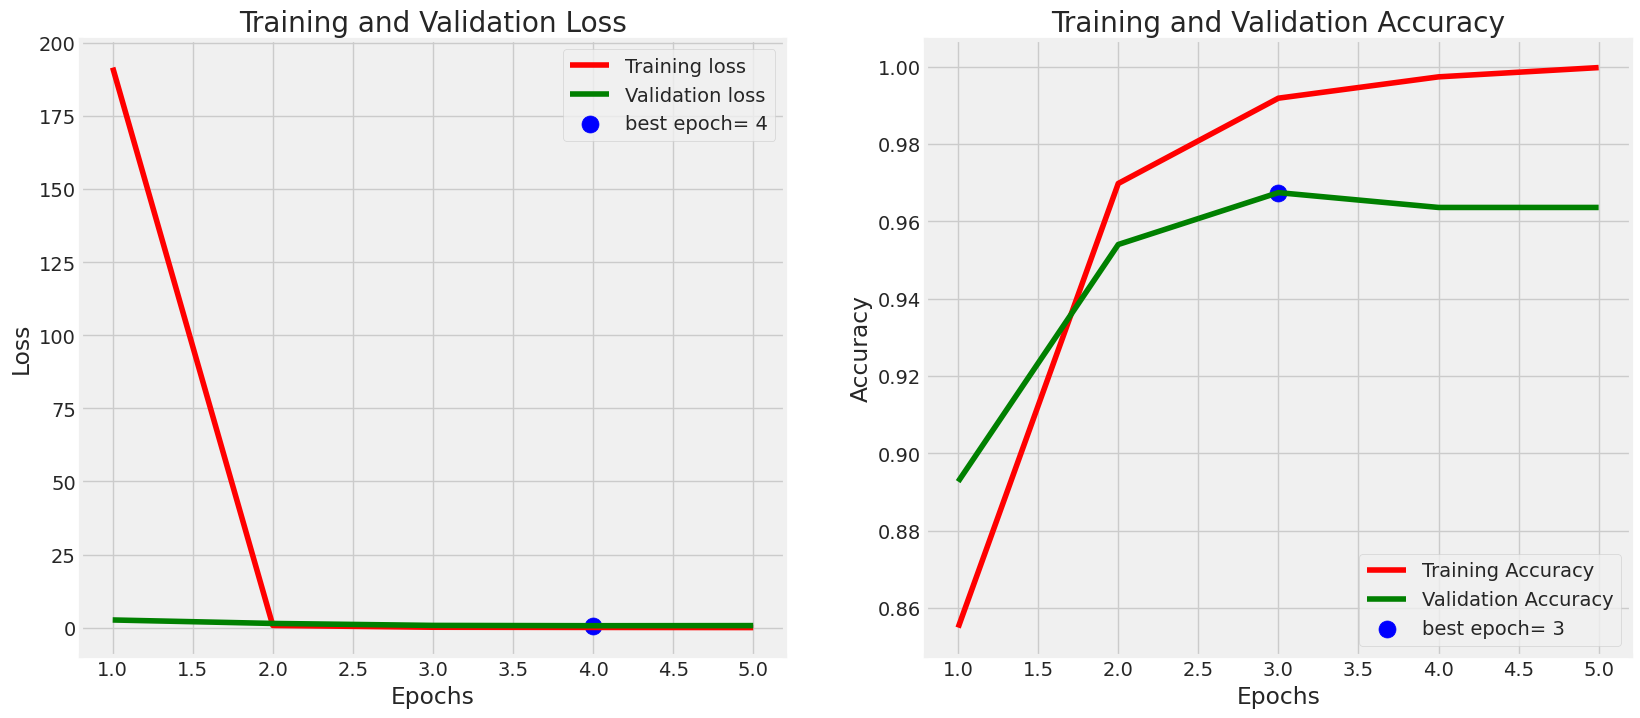

66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 604ms/step - accuracy: 0.9995 - loss: 0.0045
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 547ms/step - accuracy: 0.9718 - loss: 0.7054
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 565ms/step - accuracy: 0.9553 - loss: 0.7629
Train Loss:  0.002646521432325244
Train Accuracy:  0.9997603297233582
--------------------
Validation Loss:  0.7383689284324646
Validation Accuracy:  0.9636015295982361
--------------------
Test Loss:  0.8063708543777466
Test Accuracy:  0.9559386968612671


In [11]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 568ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       156
           1       0.98      0.96      0.97       366

    accuracy                           0.96       522
   macro avg       0.94      0.96      0.95       522
weighted avg       0.96      0.96      0.96       522



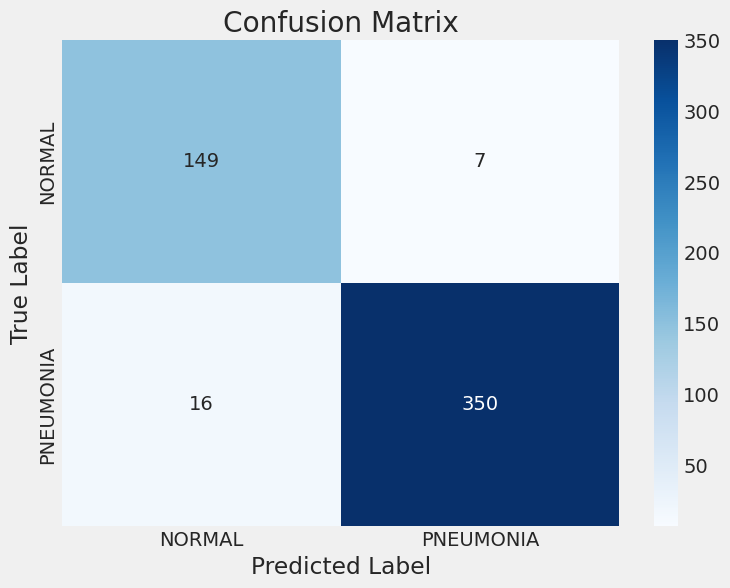

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_gen.classes

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_gen.class_indices.keys(), 
            yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ activation[0][0], │
│                     │ 64)               │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 224, 224,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 224, 224,  │         65 │ activation_2[0][… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 224, 224,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ input_layer[0][0… │
│                     │ 3)                │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │      3,584 │ multiply[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │    147,584 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 112, 112,  │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │    147,584 │ activation_4[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 112, 112,  │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 112, 112,  │          0 │ activation_4[0][

 Total params: 617,601,230 (2.30 GB)

 Trainable params: 205,867,076 (785.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 411,734,154 (1.53 GB)

# Saving and Inference

In [14]:
# Save the model
model.save('/kaggle/working/Classfication_model.h5')

In [19]:
from tensorflow.keras.models import load_model
from PIL import Image

# Load the saved model
loaded_model = model

# Define class labels
class_labels = ["NORMAL", "PNEUMONIA"]

# Function to preprocess the input image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.repeat(img, 3, axis=-1)  # Repeat grayscale image to have 3 channels
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions
def predict_image(model, image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    return prediction

# Function to get predicted class and probability
def get_predicted_class(prediction):
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    probability = prediction[0][predicted_class_index]
    return predicted_class, probability

# Example usage
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg'
prediction = predict_image(loaded_model, image_path)
predicted_class, probability = get_predicted_class(prediction)
print("Predicted Class:", predicted_class)
print("Probability:", probability)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class: PNEUMONIA
Probability: 0.60925066
